In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Chargement Jeux de données

In [148]:
textFile = pd.read_csv('openfoodfacts.csv', error_bad_lines=False,low_memory=False, chunksize=10**5, sep='\t')

/var/folders/x4/5yq5_q792r58vht_w3fmzyvh0000gn/T/ipykernel_3827/3385766680.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  textFile = pd.read_csv('openfoodfacts.csv', error_bad_lines=False,low_memory=False, chunksize=10**5, sep='\t')


In [151]:
openFood = pd.concat(textFile, ignore_index=True)

Nombre de ligne et de colonne du dataframe

In [152]:
openFood.shape

(2033614, 187)

In [153]:
openFood.dtypes

code                   object
url                    object
creator                object
created_t               int64
created_datetime       object
                       ...   
choline_100g          float64
phylloquinone_100g    float64
beta-glucan_100g      float64
inositol_100g         float64
carnitine_100g        float64
Length: 187, dtype: object

In [154]:
openFood.head(2)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Selection de variable pour notre application

In [155]:
listColumns = ['product_name','additives_n', 'origins','trans-fat_100g', 'sugars_100g', 'ingredients_from_palm_oil_n', 'salt_100g','nutriscore_grade','nutrition-score-fr_100g']

Filtre sur une liste de colonne

In [156]:
openFood_filtred = openFood[listColumns]

In [157]:
openFood_filtred.describe()

,additives_n,trans-fat_100g,sugars_100g,ingredients_from_palm_oil_n,salt_100g,nutrition-score-fr_100g
count,728347.000000,265010.000000,1.584398e+06,728347.000000,1.510889e+06,726017.000000
mean,2.025644,0.145396,6.311547e+07,0.020223,2.231864e+00,9.110962
std,2.895511,29.484580,7.944524e+10,0.142679,1.204497e+02,8.847891
min,0.000000,0.000000,-1.000000e+00,0.000000,0.000000e+00,-15.000000
25%,0.000000,0.000000,6.000000e-01,0.000000,8.000000e-02,1.000000
50%,1.000000,0.000000,3.570000e+00,0.000000,5.750000e-01,10.000000
75%,3.000000,0.000000,1.750000e+01,0.000000,1.400000e+00,16.000000
max,49.000000,14800.000000,1.000000e+14,3.000000,7.500000e+04,40.000000


## Moyenne des valeurs non renseignées par colonne

In [158]:
meanNAbycolumn = openFood_filtred.isna().mean().to_frame()

In [159]:
meanNAbycolumn

,0
product_name,0.040749
additives_n,0.641846
origins,0.957387
trans-fat_100g,0.869685
sugars_100g,0.220895
ingredients_from_palm_oil_n,0.641846
salt_100g,0.257042
nutriscore_grade,0.642994
nutrition-score-fr_100g,0.642992


In [160]:
openFood_filtred.shape

(2033614, 9)

La colonne product_name possède peu de NAN

On filtre les données manquantes de la colonne product_name

In [161]:
openFood_filtred = openFood_filtred[openFood_filtred['product_name'].notna()]

In [162]:
openFood_filtred.isna().mean().to_frame()

,0
product_name,0.000000
additives_n,0.630215
origins,0.956061
trans-fat_100g,0.864358
sugars_100g,0.191922
ingredients_from_palm_oil_n,0.630215
salt_100g,0.228855
nutriscore_grade,0.629230
nutrition-score-fr_100g,0.629228


### Analyse avant traitement NAN

Les listes pour chaque type de feature

In [163]:
listNumerical = openFood_filtred.select_dtypes(include=['float64','int64']).columns
listCategorical = openFood_filtred.select_dtypes(include=['object']).columns
listOrdinal = listCategorical[2:]
listNominal = listCategorical[:2]
features = listNominal.tolist() + listNumerical.tolist() + listOrdinal.tolist()

### Aperçu des valeurs les plus représentées

In [164]:
openFood_filtred[listNominal[0]].value_counts()

Miel                                   1356
Aceite de oliva virgen extra           1354
Filet de poulet                        1094
Comté                                   964
Ice cream                               762
                                       ... 
Blendes scotch whisky                     1
William Peel Scotch Whisky                1
William Peel Magnum 175CL 40°             1
William Peel Double Maturation 70CL       1
Signal Toothpaste                         1
Name: product_name, Length: 1265059, dtype: int64

In [165]:
openFood_filtred[listNominal[1]].value_counts()

France                                                        22019
México                                                         1909
España                                                         1596
Union Européenne                                               1547
Deutschland                                                    1404
                                                              ...  
Argetine,Chili,Pérou,Vietnam,Îles Feroé                           1
Pérou,Argentine,Vietnam                                           1
viande issues d'animaux d'origine france                          1
Unicognac S. A.                                                   1
Vegetable Glycerin, Propylene Glycol, Flavouring, Nicotine        1
Name: origins, Length: 13662, dtype: int64

In [166]:
openFood_filtred[listOrdinal].value_counts()

nutriscore_grade
d                   224722
c                   155653
e                   133198
a                   115547
b                    94159
dtype: int64

In [167]:
openFood_filtred['sugars_100g'].sort_values(ascending = False)

2026319    1.000000e+14
1955239    1.000000e+06
1299376    5.670000e+04
799914     2.700000e+04
1993487    4.466667e+03
               ...     
2033604             NaN
2033607             NaN
2033609             NaN
2033610             NaN
2033613             NaN
Name: sugars_100g, Length: 1950747, dtype: float64

In [168]:
openFood_filtred[openFood_filtred['sugars_100g'] > 4.466667e+03]

,product_name,additives_n,origins,trans-fat_100g,sugars_100g,ingredients_from_palm_oil_n,salt_100g,nutriscore_grade,nutrition-score-fr_100g
799914,Nems crevette cabillaud et sauce nuoc mam,1.0,NaN,NaN,2.700000e+04,0.0,14000.0,e,40.0
1299376,Great Taste White,6.0,NaN,NaN,5.670000e+04,0.0,125.0,NaN,NaN
1955239,Chocokoek,NaN,NaN,NaN,1.000000e+06,NaN,NaN,NaN,NaN
2026319,Vanille biscuits,NaN,NaN,NaN,1.000000e+14,NaN,NaN,NaN,NaN


## Méthode de nettoyage - valeurs manquantes

## Suppréssion de doublon

In [169]:
openFood_filtred = openFood_filtred.drop_duplicates()

## Valeurs Manquantes

### Filling NA

In [170]:
openFood_filtred['origins'].value_counts()

France                                                        20700
México                                                         1854
Union Européenne                                               1529
España                                                         1463
Deutschland                                                    1381
                                                              ...  
Coteaux Nantais                                                   1
Vercheny,Drôme,France                                             1
Argentine,Chili,Pérou,Viêt Nam                                    1
Argetine,Chili,Pérou,Vietnam,Îles Feroé                           1
Vegetable Glycerin, Propylene Glycol, Flavouring, Nicotine        1
Name: origins, Length: 13662, dtype: int64

En terme de recensement, on choisit le 2ème pays afin d'éviter d'accentuer la présence de la France

In [171]:
openFood_filtred['origins'].fillna("México", inplace=True)

In [172]:
openFood_filtred['origins'].value_counts()

México                                                        1680278
France                                                          20700
Union Européenne                                                 1529
España                                                           1463
Deutschland                                                      1381
                                                               ...   
Coteaux Nantais                                                     1
Vercheny,Drôme,France                                               1
Argentine,Chili,Pérou,Viêt Nam                                      1
Argetine,Chili,Pérou,Vietnam,Îles Feroé                             1
Vegetable Glycerin, Propylene Glycol, Flavouring, Nicotine          1
Name: origins, Length: 13662, dtype: int64

Récapitulatif des valeurs manquantes

In [173]:
openFood_filtred.isna().mean().to_frame()

,0
product_name,0.000000
additives_n,0.612214
origins,0.000000
trans-fat_100g,0.861908
sugars_100g,0.168090
ingredients_from_palm_oil_n,0.612214
salt_100g,0.207383
nutriscore_grade,0.619229
nutrition-score-fr_100g,0.619227


### Remplacer les NAN

In [174]:
openFood_filtred['nutriscore_grade'].value_counts()

d    207671
c    143712
e    126504
a    104573
b     88424
Name: nutriscore_grade, dtype: int64

In [175]:
openFood_filtred['nutriscore_grade'].replace([np.nan], "c", inplace=True)

In [176]:
openFood_filtred['nutriscore_grade'].value_counts()

c    1234738
d     207671
e     126504
a     104573
b      88424
Name: nutriscore_grade, dtype: int64

Récapitulatif des valeurs manquantes

In [177]:
openFood_filtred.isna().mean().to_frame()

,0
product_name,0.000000
additives_n,0.612214
origins,0.000000
trans-fat_100g,0.861908
sugars_100g,0.168090
ingredients_from_palm_oil_n,0.612214
salt_100g,0.207383
nutriscore_grade,0.000000
nutrition-score-fr_100g,0.619227


In [178]:
openFood_filtred['trans-fat_100g'].value_counts()

0.0000     237422
0.1000        363
0.2000        300
1.0000        130
0.4000        121
            ...  
0.2610          1
0.0833          1
0.9930          1
4.6500          1
90.0000         1
Name: trans-fat_100g, Length: 564, dtype: int64

In [179]:
#for i in listNumerical:
#    b[i] = openFood_filtred[i].interpolate(method ='linear', limit_direction ='backward', inplace=True)

## Simple imputer

Notre simple imputer s'applique uniquement sur les variables quantitative, on va devoir scinder le dataframe en 2

In [180]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(openFood_filtred[listNumerical])
openFood_data_array = imp_median.transform(openFood_filtred[listNumerical])

In [181]:
openFood_data_df = pd.DataFrame(openFood_data_array, columns = listNumerical)

In [182]:
openFood_data_df

,additives_n,trans-fat_100g,sugars_100g,ingredients_from_palm_oil_n,salt_100g,nutrition-score-fr_100g
0,1.0,0.0,3.8,0.0,0.5725,10.0
1,0.0,0.0,9.8,0.0,0.1000,10.0
2,1.0,0.0,15.0,0.0,1.4000,10.0
3,1.0,0.0,3.8,0.0,0.5725,10.0
4,1.0,0.0,3.8,0.0,1.1000,10.0
...,...,...,...,...,...,...
1761905,1.0,0.0,1.0,0.0,1.0000,10.0
1761906,1.0,0.0,3.8,0.0,0.5725,10.0
1761907,1.0,0.0,0.6,0.0,0.6400,10.0
1761908,1.0,0.0,7.8,0.0,0.1500,10.0


In [183]:
openFood_filtred_categorical_df = openFood_filtred[listCategorical]

In [184]:
openFood_data = pd.concat([openFood_filtred_categorical_df, openFood_data_df], axis=1, join='inner')

In [185]:
openFood_data

,product_name,origins,nutriscore_grade,additives_n,trans-fat_100g,sugars_100g,ingredients_from_palm_oil_n,salt_100g,nutrition-score-fr_100g
0,jeunes pousses,México,c,1.0,0.0,3.8,0.0,0.5725,10.0
1,L.casei,Spain,c,0.0,0.0,9.8,0.0,0.1000,10.0
2,Vitória crackers,México,c,1.0,0.0,15.0,0.0,1.4000,10.0
3,Cacao,México,c,1.0,0.0,3.8,0.0,0.5725,10.0
4,Filetes de pollo empanado,México,c,1.0,0.0,3.8,0.0,1.1000,10.0
...,...,...,...,...,...,...,...,...,...
1761905,Yopro banana & peanut,México,c,1.0,0.0,1.0,0.0,1.0000,10.0
1761906,Oikos the ice cream,México,c,1.0,0.0,3.8,0.0,0.5725,10.0
1761907,Oikos,México,c,1.0,0.0,0.6,0.0,0.6400,10.0
1761908,Yorgurt,México,c,1.0,0.0,7.8,0.0,0.1500,10.0


In [186]:
openFood_data.apply(pd.Series.nunique)

product_name                   1109461
origins                          12602
nutriscore_grade                     5
additives_n                         39
trans-fat_100g                     523
sugars_100g                      16673
ingredients_from_palm_oil_n          4
salt_100g                        23021
nutrition-score-fr_100g             56
dtype: int64

In [187]:
openFood_data.isna().mean().to_frame()

,0
product_name,0.0
origins,0.0
nutriscore_grade,0.0
additives_n,0.0
trans-fat_100g,0.0
sugars_100g,0.0
ingredients_from_palm_oil_n,0.0
salt_100g,0.0
nutrition-score-fr_100g,0.0


Nombre de ligne et de colonne

In [188]:
openFood_data.shape

(1531985, 9)

In [189]:
openFood_data.head(4)

,product_name,origins,nutriscore_grade,additives_n,trans-fat_100g,sugars_100g,ingredients_from_palm_oil_n,salt_100g,nutrition-score-fr_100g
0,jeunes pousses,México,c,1.0,0.0,3.8,0.0,0.5725,10.0
1,L.casei,Spain,c,0.0,0.0,9.8,0.0,0.1000,10.0
2,Vitória crackers,México,c,1.0,0.0,15.0,0.0,1.4000,10.0
3,Cacao,México,c,1.0,0.0,3.8,0.0,0.5725,10.0


# Outliers

## Analyse

In [190]:
openFood_data_numerical = openFood_data[listNumerical]

In [191]:
openFood_data_categorical = openFood_data[listCategorical]

Calcul du percentile par rapport aux valeurs des variables numériques

On calcule le percentile de chaque feature entre 5 et 101

In [192]:
df_outlier_numerical = pd.DataFrame()
for j in openFood_data_numerical.columns:
    for k in np.arange(5, 101, 5):
        df_outlier_numerical.at[k, j] = np.percentile(openFood_data_numerical[j],k)

#### Visualisation des percentiles pour les variables numériques

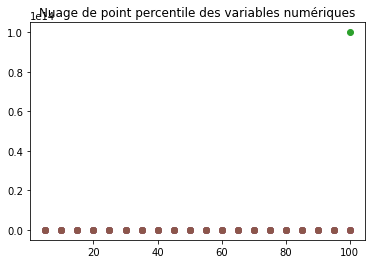

In [193]:
for i in df_outlier_numerical.columns:
    plt.scatter(df_outlier_numerical.index,df_outlier_numerical[i])
    plt.title('Nuage de point percentile des variables numériques')
#plt.savefig('Nuage_percentile.png')

Nuage de point percentile sel

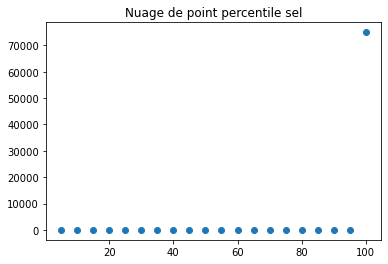

In [194]:
plt.title('Nuage de point percentile sel')
plt.scatter(df_outlier_numerical.index,df_outlier_numerical['salt_100g'])

Nuage de point percentile sucre

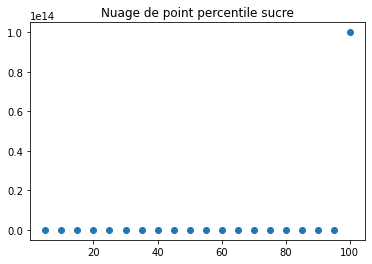

In [195]:
plt.title('Nuage de point percentile sucre')
plt.scatter(df_outlier_numerical.index,df_outlier_numerical['sugars_100g'])

Nuage de point percentile trans-fat_100g

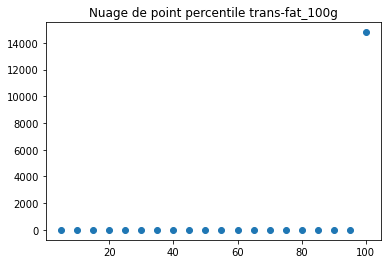

In [196]:
plt.title('Nuage de point percentile trans-fat_100g')
plt.scatter(df_outlier_numerical.index,df_outlier_numerical['trans-fat_100g'])

## Supprimer les outliers

#### Filtre les données avec le percentile

Pour chaque featureLe 70e centile devient la valeur maximale 

In [197]:
#Dénombrement des outliers, observation des percentiles superieur au 70e centile sur chaque colonne 
for i in openFood_data_numerical.columns:
    print(openFood_data_numerical[openFood_data_numerical[i] > np.percentile(openFood_data_numerical[i],70)].shape)

(244582, 6)
(5195, 6)
(459186, 6)
(12278, 6)
(458159, 6)
(282858, 6)


La valeur 70 a été choisie pour faciliter l'analyse (capacité de calcul)

On determine les index des outliers

In [198]:
totalOutlier = []
for i in openFood_data_numerical.columns:
    totalOutlier += openFood_data_numerical[openFood_data_numerical[i] > np.percentile(openFood_data_numerical[i],70)].index.tolist()

In [199]:
len(totalOutlier)

1462258

In [200]:
tOtalDrop = np.unique(totalOutlier).tolist()

In [201]:
len(tOtalDrop)

928142

In [202]:
openFood_data.shape

(1531985, 9)

suppréssion des index des outliers

In [203]:
df_openFood_data = openFood_data.drop(tOtalDrop)

In [204]:
df_openFood_data.shape

(603843, 9)

# Verification suppréssion des outliers des variables numériques

In [205]:
df_outlier_numerica = pd.DataFrame()
for j in listNumerical:
    for k in np.arange(99.01, 100, 0.001):
        df_outlier_numerica.at[k, j] = np.percentile(df_openFood_data[j],k)

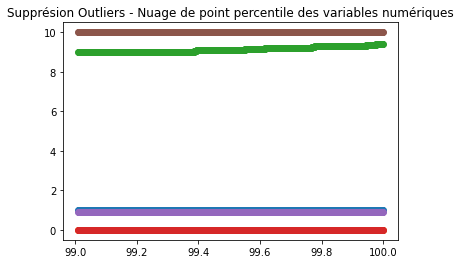

In [206]:
for i in df_outlier_numerical.columns:
    plt.scatter(df_outlier_numerica.index,df_outlier_numerica[i])
    plt.title('Supprésion Outliers - Nuage de point percentile des variables numériques')
#plt.savefig('Apres_Nuage_percentile.png')

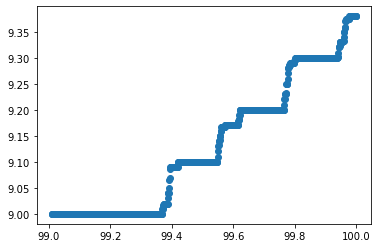

In [207]:
#plt.title('Nuage de point percentile sel')
plt.scatter(df_outlier_numerica.index,df_outlier_numerica['sugars_100g'])

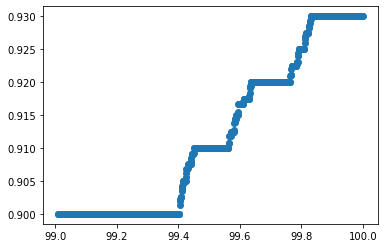

In [208]:
#plt.title('Nuage de point percentile sel')
plt.scatter(df_outlier_numerica.index,df_outlier_numerica['salt_100g'])

Verification des valeurs extrèmes par feature

Avant

In [209]:
openFood_data['salt_100g'].sort_values(ascending = False)

67708      75000.0
67709      69400.0
37164      62500.0
321397     39390.0
1160607    38000.0
            ...   
1593186        0.0
1593187        0.0
199486         0.0
943857         0.0
393119         0.0
Name: salt_100g, Length: 1531985, dtype: float64

Après

In [210]:
df_openFood_data['trans-fat_100g'].sort_values(ascending = False)

0          0.0
1239175    0.0
1239156    0.0
1239157    0.0
1239159    0.0
          ... 
704474     0.0
704475     0.0
704483     0.0
704486     0.0
1761909    0.0
Name: trans-fat_100g, Length: 603843, dtype: float64

Avant

In [211]:
openFood_data['nutrition-score-fr_100g'].sort_values(ascending = False)

121427     40.0
593894     40.0
1087304    40.0
1741384    40.0
1720965    40.0
           ... 
723358    -14.0
246290    -14.0
313208    -15.0
1323805   -15.0
714136    -15.0
Name: nutrition-score-fr_100g, Length: 1531985, dtype: float64

Après

In [212]:
df_openFood_data['nutrition-score-fr_100g'].sort_values(ascending = False)

0          10.0
1188699    10.0
1188721    10.0
1188720    10.0
1188717    10.0
           ... 
311724    -14.0
9164      -14.0
1323805   -15.0
313208    -15.0
714136    -15.0
Name: nutrition-score-fr_100g, Length: 603843, dtype: float64

Avant

In [213]:
openFood_data['salt_100g'].sort_values(ascending = False)

67708      75000.0
67709      69400.0
37164      62500.0
321397     39390.0
1160607    38000.0
            ...   
1593186        0.0
1593187        0.0
199486         0.0
943857         0.0
393119         0.0
Name: salt_100g, Length: 1531985, dtype: float64

Après

In [214]:
df_openFood_data['salt_100g'].sort_values(ascending = False)

1358065    0.93
883841     0.93
1343463    0.93
883944     0.93
568969     0.93
           ... 
1418627    0.00
1418623    0.00
323854     0.00
1418591    0.00
449062     0.00
Name: salt_100g, Length: 603843, dtype: float64

Avant

In [215]:
openFood_data['sugars_100g'].sort_values(ascending = False)

1755189    1.000000e+14
1695073    1.000000e+06
1127696    5.670000e+04
683652     2.700000e+04
1727533    4.466667e+03
               ...     
1616866    0.000000e+00
608870    -5.000000e-01
1249749   -5.000000e-01
989310    -1.000000e+00
1321748   -1.000000e+00
Name: sugars_100g, Length: 1531985, dtype: float64

Après

In [216]:
df_openFood_data['sugars_100g'].sort_values(ascending = False)

128336     9.38
417544     9.38
425486     9.38
245450     9.38
398268     9.38
           ... 
1357185    0.00
1357184    0.00
366602     0.00
1321748   -1.00
989310    -1.00
Name: sugars_100g, Length: 603843, dtype: float64

### Traitement des valeurs aberrantes - négatives

In [217]:
df_openFood_dataFinal = df_openFood_data[df_openFood_data.select_dtypes(include=[np.number]).ge(0).all(1)]

In [219]:
df_openFood_dataFinal['sugars_100g'].sort_values(ascending = False)

255169     9.38
377425     9.38
138286     9.38
417567     9.38
73160      9.38
           ... 
1221792    0.00
1221793    0.00
1221794    0.00
1221795    0.00
866820     0.00
Name: sugars_100g, Length: 537827, dtype: float64

In [220]:
df_openFood_dataFinal['nutrition-score-fr_100g'].sort_values(ascending = False)

0          10.0
1232556    10.0
1232576    10.0
1232575    10.0
1232572    10.0
           ... 
365684      0.0
1391195     0.0
690301      0.0
1345397     0.0
1717742     0.0
Name: nutrition-score-fr_100g, Length: 537827, dtype: float64

In [221]:
 df_openFood_dataFinal.columns

Index(['product_name', 'origins', 'nutriscore_grade', 'additives_n',
       'trans-fat_100g', 'sugars_100g', 'ingredients_from_palm_oil_n',
       'salt_100g', 'nutrition-score-fr_100g'],
      dtype='object')

# Sauvegarde dataframe

In [222]:
#df_openFood_dataFinal.to_csv("openFoodV2.csv", index=False)